In [ ]:
import scanpy as sc
import squidpy as sq

from Algorithm.distribution import *
from util import *

In [ ]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

In [311]:
test = sc.read_h5ad('F://Rep11_MOB_ST.h5ad')
position_list = list(test.obs.index.str.split('x'))
arr = np.array(position_list, dtype=np.float32).reshape(len(position_list), 2)
test.obs['fig_x'] = arr[:,0] * 1000
test.obs['fig_y'] = arr[:,1] * 1000

F:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


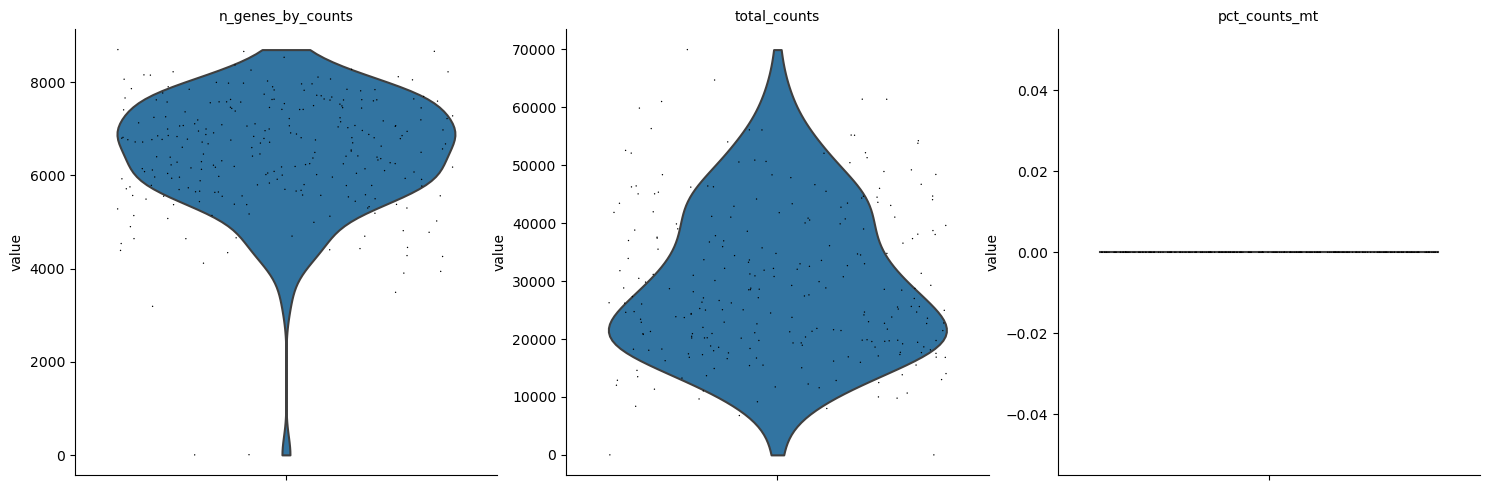

In [312]:
h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata = test
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [ ]:
sc.pp.filter_genes(adata, min_cells=20)
adata

In [ ]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [ ]:
gene_list = adata.var[adata.var['highly_variable']==True].index
len(gene_list)

In [437]:
def get_3d_matrix(adata: anndata):
    """
    get the 3D matrix for adata
    """
    x_max = int(adata.obs['fig_x'].max())
    y_max = int(adata.obs['fig_y'].max())
    # the spatial coordinates should be in adata.obs
    three_d_array = np.zeros((int(x_max), int(y_max), int(adata.var.shape[0])))
    print('Transfer anndata to 3D matrix...')
    for spot in tqdm(adata, bar_format='{l_bar}{bar:20}{r_bar}{percentage:3.0f}%'):
        x = int(spot.obs['fig_x']) - 1
        y = int(spot.obs['fig_y']) - 1
        three_d_array[x, y] = spot.X.toarray()
    return three_d_array

gene_list = ['Ccnl1']
mat = get_3d_matrix(adata[:, gene_list])
mat

Transfer anndata to 3D matrix...


100%|████████████████████| 262/262 [00:00<00:00, 970.36it/s]100%


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [465]:
mat = mat[:,:,0]

In [471]:
for index,row in enumerate(mat):
    if np.sum(row)>0:
        print(index)
        break

for index,col in enumerate(mat.T):
    if np.sum(col)>0:
        print(index)
        break


7887
9014


In [313]:
paper = ['Rab3b','Necab2','Tspan7','Cdr1','Slc17a7','4933405L10Rik','Taf7l','Gna14','Olfr635','Pmepa1','Pcp4','Apc','Rbfox3','Penk','Frzb','Fabp7','Slc6a11','Apod','S100a5','Arhgap33','Cplx1','Trnp1','Marcks','Atp1b1','Vtn','Trak2','Igf1','Gabra1','Igfbp2','Lpar1','Omp','Kif5b','Sorbs1','Cck','Nr2f2','Scd1','Cpe','Aqp4','Doc2g','Slc1a2','Nrgn','Cdhr1','Mcf2l','Kctd12','Unc13c','Foxd3','Prokr2','Gng13','Kcnh3','Camk2b','Baiap2','Ccnd1','Gpsm1','Pbx1','Sepp1','Apoe','Tubb2b','Ncdn','Glul','Sash1','Ptgds','Sparcl1','Mbp','Nrsn1','Igfbp5','Ptn','Sfrp5']

In [314]:
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
gene_list

Index(['Pmepa1', 'Pcp4', 'Apc', 'Rbfox3', 'Gng13', 'Penk', 'Frzb', 'Kcnh3',
       'Fabp7', 'Camk2b', 'Baiap2', 'Slc6a11', 'Ccnd1', 'Apod', 'S100a5',
       'Arhgap33', 'Cplx1', 'Rab3b', 'Trnp1', 'Gpsm1', 'Pbx1', 'Marcks',
       'Atp1b1', 'Sepp1', 'Vtn', 'Apoe', 'Trak2', 'Igf1', 'Gabra1', 'Tubb2b',
       'Igfbp2', 'Lpar1', 'Omp', 'Kif5b', 'Ncdn', 'Glul', 'Sorbs1', 'Sash1',
       'Cck', 'Ptgds', 'Nr2f2', 'Sparcl1', 'Scd1', 'Cpe', 'Necab2', 'Tspan7',
       'Aqp4', 'Cdr1', 'Mbp', 'Doc2g', 'Slc1a2', 'Slc17a7', 'Nrgn', 'Cdhr1',
       'Mcf2l', 'Kctd12', 'Nrsn1', 'Igfbp5', 'Ptn', 'Unc13c', 'Foxd3',
       'Prokr2', 'Sfrp5', 'Taf7l', 'Gna14', 'Olfr635'],
      dtype='object')

In [317]:
len(gene_list)

66

In [316]:
from Algorithm.graph import *
gmm_dict = fit_gmms(adata, gene_list, n_comp=10)

In [ ]:
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              color=list(['Vtn']))

In [ ]:
gmm = fit_gmm(adata,'Vtn', n_comp=25)
view_gmm(gmm, plot_type = '2d')
gmm.covariances_

In [461]:
from scipy.sparse import csr_matrix
li = []

for i in range(20):
    li.append(csr_matrix(np.array(np.random.random((100,100)))))

In [532]:
adata[:,'Slc17a7'].obs['fig_x'].values

array([16920.   , 16945.   , 16970.   , 16939.   , 16949.   , 16942.   ,
       16941.   , 16919.   ,  9862.   , 12080.   , 10802.   , 13979.   ,
       15008.   , 15949.   , 15944.   , 15002.   , 15004.   , 15968.   ,
       13095.   , 13980.   , 13044.   , 14012.   , 14025.   , 13030.   ,
       13071.   , 14011.   , 15941.   , 15041.   , 15044.   , 15919.   ,
       10861.   , 12009.   , 12053.   , 10877.   ,  9865.   ,  9904.   ,
        9894.   ,  9876.   , 12025.   , 10901.   , 10897.   , 12054.   ,
       12033.   , 10927.   , 12156.   , 10918.   ,  9853.   ,  9846.   ,
        9903.   ,  9938.   , 11996.   , 12138.   , 10882.   , 10922.   ,
       15042.   , 15959.   , 15052.   , 15929.   , 13045.   , 14016.   ,
       13988.   , 12988.   , 13020.   , 13004.   , 14042.   , 14068.   ,
       16000.999, 15026.   , 15987.   , 15003.   , 15965.   , 15979.   ,
       15982.   , 15087.   , 15043.   , 15030.   , 13963.   , 14018.   ,
       13051.   , 13039.   , 14024.   , 13075.   , 

In [576]:
def build_distance_array(gmm_dict: dict):
    # build graph
    gene_list = list(gmm_dict.keys())
    gene_counts = len(gene_list)
    distance_matrix = np.zeros((gene_counts, gene_counts), dtype=np.float64)
    # calculate the weight and add edges
    for i in range(gene_counts):
        for j in range(gene_counts):
            if i != j:
                distance = distribution_distance(gmm_dict[gene_list[i]], gmm_dict[gene_list[j]])
                distance_matrix[i][j] = distance
    return distance_matrix

arr = build_distance_array(gmm_dict)

In [419]:
g=build_graph(gmm_dict, distance_threshold=5)

In [389]:
M_norm_minmax = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
M_norm_minmax

1.0

In [556]:
distance_matrix = arr
min_distance = np.min(distance_matrix)
max_distance = np.max(distance_matrix)
normalized_distance_matrix = (distance_matrix - min_distance) / (max_distance - min_distance)

# 高斯核函数
similarity_matrix = np.exp(-normalized_distance_matrix**2 / (2 * 0.5**2))
# 构造拉普拉斯矩阵
D = np.diag(np.sum(similarity_matrix, axis=1))
L = D - similarity_matrix

# 进行特征值分解
eigenvalues, eigenvectors = np.linalg.eig(L)
idx = np.argsort(eigenvalues)[:3]
X = eigenvectors[:, idx]

# 对特征向量进行聚类
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors')
spectral.fit(X)

# 输出聚类结果
print(spectral.labels_)

[1 0 2 1 0 0 4 0 0 4 2 2 1 0 2 1 2 3 0 4 4 2 4 1 3 3 0 1 3 2 2 0 1 0 4 3 2
 3 3 2 1 0 1 1 4 1 4 2 2 0 4 4 0 4 2 3 2 3 0 2 0 3 3 3 2 3]


In [ ]:
from sklearn.cluster import SpectralClustering

k = 5  # 聚类数
clustering_model = SpectralClustering(n_clusters=k, affinity='precomputed', n_init=10)
clustering_model.fit(test)

# 打印聚类结果
print("Cluster labels:", clustering_model.labels_)

In [ ]:
len(list(clustering_model.labels_))

In [619]:
from sklearn.manifold import MDS
distance_matrix=arr
# distance_matrix为距离矩阵
mds = MDS(n_components=10, dissimilarity='precomputed')
embedding = mds.fit_transform(distance_matrix)

from sklearn.cluster import KMeans
# embedding为映射矩阵，n_clusters为聚类数目
kmeans = KMeans(n_clusters=6, random_state=0).fit(embedding)
# 获取聚类标签
labels = kmeans.labels_
labels

array([2, 5, 2, 1, 5, 5, 1, 5, 5, 5, 1, 2, 4, 5, 4, 1, 4, 2, 5, 4, 5, 1,
       1, 2, 1, 2, 5, 4, 4, 2, 2, 4, 1, 5, 1, 2, 4, 2, 2, 4, 1, 5, 2, 4,
       4, 4, 4, 4, 4, 5, 4, 1, 5, 4, 4, 2, 1, 2, 5, 3, 0, 0, 0, 2, 4, 1])

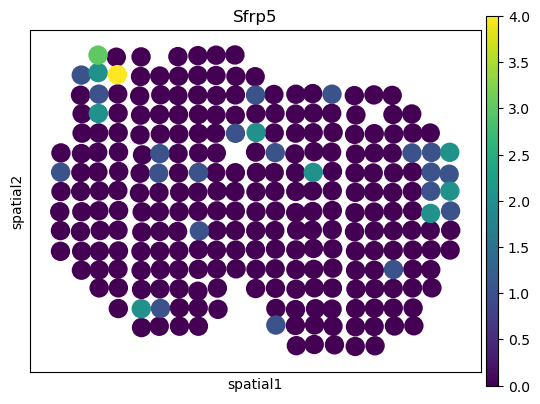

In [627]:
df = pd.DataFrame({'gene':list(gmm_dict.keys()), 'labels':list(kmeans.labels_)})
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              color=list(df[df['labels']==3]['gene']))

In [594]:
list(df[df['labels']==0]['gene'])

['Pmepa1',
 'Gng13',
 'Frzb',
 'Ccnd1',
 'S100a5',
 'Fabp7',
 'Apod',
 'Vtn',
 'Marcks',
 'Trak2',
 'Igf1',
 'Sepp1',
 'Lpar1',
 'Omp',
 'Kif5b',
 'Sorbs1',
 'Sash1',
 'Nr2f2',
 'Ptgds',
 'Scd1',
 'Apoe',
 'Mcf2l',
 'Ptn',
 'Unc13c',
 'Foxd3',
 'Igfbp5',
 'Kctd12']

In [567]:
def build_distance_array(gmm_dict: dict):
    # build graph
    gene_list = list(gmm_dict.keys())
    gene_counts = len(gene_list)
    distance_matrix = np.zeros((gene_counts, gene_counts), dtype=np.float64)
    # calculate the weight and add edges
    for i in range(gene_counts):
        for j in range(gene_counts):
            if i != j:
                distance = distribution_distance(gmm_dict[gene_list[i]], gmm_dict[gene_list[j]])
                distance_matrix[i][j] = distance
    return distance_matrix
a={}
for i in list(gmm_dict.keys()):
    a[i] = gmm_dict[i]
aa = build_distance_array(a)
distance_matrix = aa
min_distance = np.min(distance_matrix)
max_distance = np.max(distance_matrix)
normalized_distance_matrix = (distance_matrix - min_distance) / (max_distance - min_distance)
similarity_matrix = np.exp(-normalized_distance_matrix**2 / (2 * 0.5**2))
similarity_matrix

array([[1.        , 0.19473819, 0.28049892, 0.33578286, 0.69600858],
       [0.19473819, 1.        , 0.2632477 , 0.32892342, 0.13533528],
       [0.28049892, 0.2632477 , 1.        , 0.5243196 , 0.17954595],
       [0.33578286, 0.32892342, 0.5243196 , 1.        , 0.26497051],
       [0.69600858, 0.13533528, 0.17954595, 0.26497051, 1.        ]])

In [ ]:
import networkx as nx
adj_matrix = nx.to_numpy_matrix(g)

In [ ]:
degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
laplacian_matrix = degree_matrix - adj_matrix

eigenvalues, eigenvectors = np.linalg.eig(np.asarray(laplacian_matrix))

k = 10
U = eigenvectors[:, 0:k]

normalized_U = U / np.linalg.norm(U, axis=1).reshape(-1, 1)

from sklearn.cluster import KMeans

kmeans = KMeans()
kmeans.fit(normalized_U)


plt.scatter(np.array(U[:,0]), np.array(U[:,1]), c=kmeans.labels_)
plt.show()

In [ ]:
# TODO: know why
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [ ]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
tmp = adata[(adata.obs['leiden']=='3') |
            (adata.obs['leiden']=='0')]

In [ ]:

sc.tl.pca(tmp, svd_solver='arpack')
sc.pp.neighbors(tmp, n_neighbors=20, n_pcs=50)
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color='leiden')

In [ ]:
sq.pl.spatial_scatter(tmp, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro','tcap', 'mt2'])

In [ ]:
gmm1 = fit_gmm(adata, 'mt2')
gmm2 = fit_gmm(adata, 'ptpro')

In [ ]:
distribution_distance(gmm1, gmm2)

In [ ]:
view_gmm(gmm1)

In [ ]:
view_gmm(gmm2, '2d')